In [1]:
import ee

from statgis.gee import landsat_functions, time_series_analysis, zonal_statistics, utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
sns.set_context('paper')

ee.Initialize()

In [2]:
cities_path = "projects/ee-srnarvaez/assets/municipios_colombia_100k"

cities = ee.FeatureCollection(cities_path)
cities.size().getInfo()

1122

In [3]:
la_guajira = cities.filter(ee.Filter.eq("Depto", "La Guajira"))
la_guajira_cities = [city["properties"]["MpNombre"] for city in la_guajira.getInfo()["features"]]

la_guajira_cities

['Urumita',
 'El Molino',
 'Distracción',
 'Hatonuevo',
 'Dibulla',
 'Albania',
 'Maicao',
 'Manaure',
 'La Jagua Del Pilar',
 'Villanueva',
 'San Juan Del Cesar',
 'Fonseca',
 'Barrancas',
 'Riohacha',
 'Uribia']

In [4]:
la_guajira_cities_geoms = {
    city: la_guajira.filter(ee.Filter.eq("MpNombre", city)).first().geometry()
    for city in la_guajira_cities
}

In [5]:
la_guajira_cities_data = {}
for city in la_guajira_cities:
    geom = la_guajira_cities_geoms[city]

    landsat_collection = ee.ImageCollection([])
    for code in ["LT05", "LE07", "LC08", "LC09"]:
        landsat_collection = landsat_collection.merge(
            ee.ImageCollection(f"LANDSAT/{code}/C02/T1_L2")
            .filterBounds(geom)
            .filterDate("1985-01-01", "2022-12-31")
            .map(landsat_functions.scaler)
            .map(landsat_functions.cloud_mask)
            .map(landsat_functions.rename_bands)
            .map(lambda img: img.select(["BLUE", "GREEN", "RED", "NIR", "SWIR1", "SWIR2", "TEMPERATURE"]))
            .map(lambda img: img.addBands(img.normalizedDifference(["NIR", "RED"]).rename("NDVI")))
        )
    
    chirps_collection = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate("1985-01-01", "2022-12-31")

    precipitation = time_series_analysis.resample(chirps_collection, ee.Reducer.sum(), "annual")
    ndvi = (
        time_series_analysis.resample(landsat_collection, ee.Reducer.median(), "annual")
        .map(lambda img: utils.calculate_band_number(img))
        .filter(ee.Filter.gt("bands", 0))
    )

    precipitation_data = zonal_statistics.zonal_statistics_collection(precipitation, geom, 5000, "precipitation", ee.Reducer.mean())
    ndvi_data = zonal_statistics.zonal_statistics_collection(ndvi, geom, 5000, ["NDVI", "TEMPERATURE"], ee.Reducer.mean())

    dataframe = precipitation_data.merge(ndvi_data, on="date", how="left")[["date", "precipitation", "TEMPERATURE", "NDVI"]]
    dataframe["city"] = city
    
    la_guajira_cities_data[city] = dataframe

In [6]:
dataframe = pd.concat(la_guajira_cities_data.values(), ignore_index=True, sort=False).reset_index(drop=True)
dataframe["TEMPERATURE"] = dataframe["TEMPERATURE"] - 273.15
dataframe = dataframe.rename({
    "date": "Time [Y]", "precipitation": "Precipitation [mm]", "TEMPERATURE": "Temperature [°C]", "city": "City" 
}, axis=1)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Time [Y]            570 non-null    datetime64[ns]
 1   Precipitation [mm]  570 non-null    float64       
 2   Temperature [°C]    511 non-null    float64       
 3   NDVI                511 non-null    float64       
 4   City                570 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 22.4+ KB


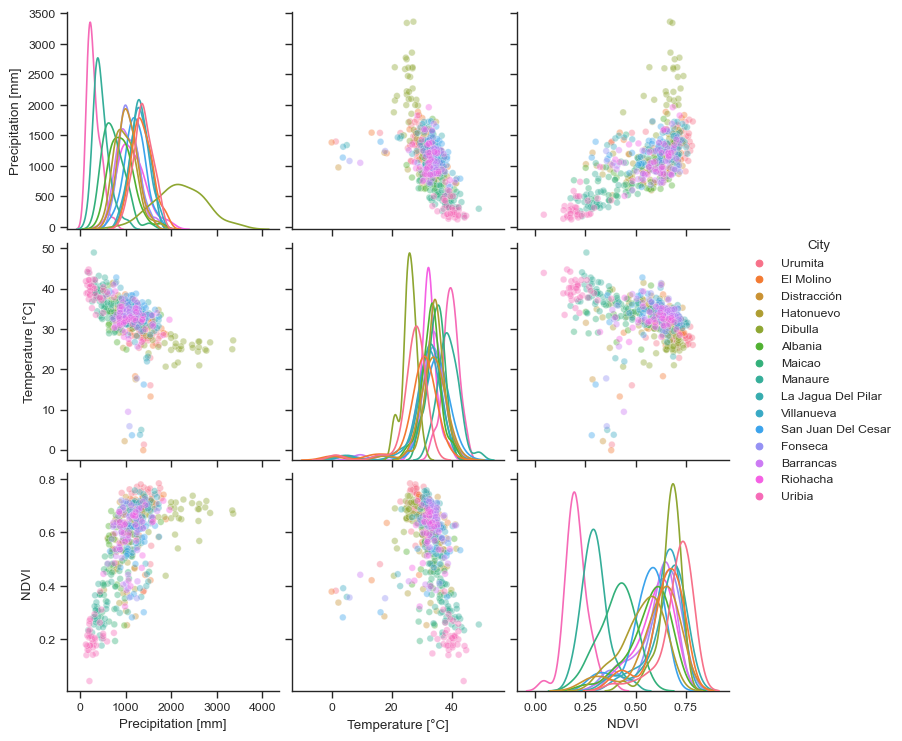

In [7]:
sns.pairplot(data=dataframe, hue="City", plot_kws={"alpha": 0.4}, diag_kws={"fill": False})
plt.show()

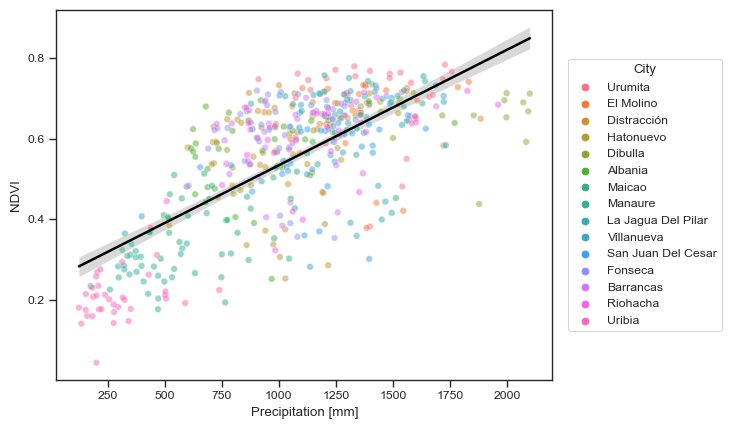

In [10]:
filtered_dataframe = dataframe.where(dataframe["Precipitation [mm]"] < 2100)

fig, ax = plt.subplots(1)
sns.regplot(data=filtered_dataframe, x="Precipitation [mm]", y="NDVI", color="black", scatter=False, ax=ax)
sns.scatterplot(data=filtered_dataframe, x="Precipitation [mm]", y="NDVI", hue="City", alpha=0.5, ax=ax)
plt.legend(title="City", bbox_to_anchor=(1.02, 0.5), loc="center left")
plt.show()

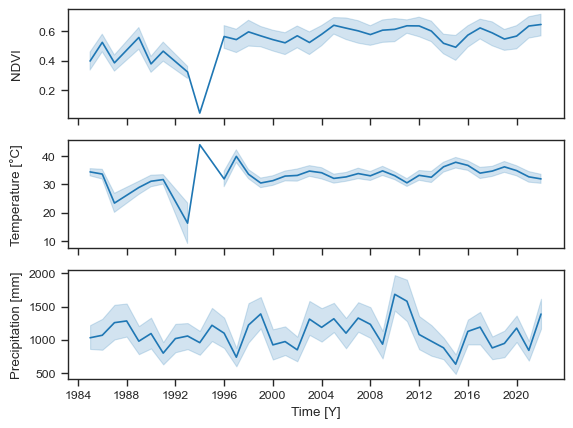

In [17]:
fig, axs = plt.subplots(3, 1, sharex=True)
sns.lineplot(data=dataframe, x="Time [Y]", y="NDVI", ax=axs[0])
sns.lineplot(data=dataframe, x="Time [Y]", y="Temperature [°C]", ax=axs[1])
sns.lineplot(data=dataframe, x="Time [Y]", y="Precipitation [mm]", ax=axs[2])
fig.align_labels()
plt.show()